In [1]:
# First import some helpful packages
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import kruskal, ttest_ind
#from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Also, I set some text formatting
sns.set_context("talk")
new_rc_params = {"text.usetex": False,
                 "svg.fonttype": 'none',
                 "savefig.dpi": 300,
                 "font.size": 12,
                 "legend.fontsize": 12,
                 #"figure.titlesize": 12,
                 "lines.linewidth": 1.0,
                }

mpl.rcParams.update(new_rc_params)

In [3]:
# Location to result files

result_dir = "/media/justus/Data/OneDrive/Dokumente/Studium/Master/Master Thesis/Results"
#result_dir = "/home/justus/Desktop/drivefuse/Dokumente/Studium/Master/Master Thesis/Results"

# Names of the experiments / files
all_experiments = ["default", "noise", "size", "time"]

# Names of the models used in groups for plotting
#ae_models = ["AE", "AE_wd"]
#vae_models = ["VAE", "VAE_beta"]
#sae_models = ["SAE", "SAE_sparse", "SAE_dense"]
#non_sae_models = ae_models + vae_models
#all_models = ae_models + vae_models + sae_models


ae_models = {"AE":"AE", "AE_wd":r"AE$_{wd}$"}
vae_models = {"VAE":"VAE", "VAE_beta":r"$\beta$VAE"}
sae_models = {"SAE":"SAE", "SAE_sparse":"sparse SAE", "SAE_dense":"dense SAE"}
non_sae_models = {**ae_models, **vae_models}
all_models = {**non_sae_models, **sae_models}

In [ ]:

"""
experiments = {
    "default": {
        "models": all_models,
        "variable": None,        
    },
    "noise": {
        "models": all_models,
        "variable": "noise",
    },
    "size": {
        "models": all_models,
        "variable": "hidden_sizes",
    },
    "time": {
        "models": sae_models,
        "variable": "steps",
    },
              }

print(experiments)
"""

In [6]:
def load_results(experiments, sort=True, rename=None):
    results = pd.DataFrame([])

    for e in experiments:
        path = Path(result_dir, f"results_{e}.csv")
        df = pd.read_csv(path)
        df["experiment"] = e
        results = pd.concat([results, df])
        
    if sort:
        results = results.sort_values(by=['model', 'seed', 'epoch'])
        
    if rename:
        results.assign(Model=map(df['model'], rename))
        
    #print(results.head())
    
    return results

In [7]:
results_default = load_results(["default"], rename=all_models)
results_noise = load_results(["default", "noise"], rename=all_models)
results_size = load_results(["default", "size"], rename=all_models)
results_time = load_results(["default", "time"], rename=all_models)

In [8]:
for c in results_default.columns:
    print(c)

epoch
name
run_id
batch_size
beta1
beta2
decay
epochs
example2
experiment
hidden_sizes
lambd1
lambd2
model
neuron1
neuron2
noise
seed
steps
test_batch_size
wd
no_cuda
verbose
dataset
loss
metrics
key_metric
goal
optimizer
epoch_batches
activation
activation_out
pooling
conv_channels
threshold
kernel_size
padding
stride
lr
eval_first
load
sample_freq
samplers
scale
encoder
decoder
grad_clip
extra_grad
reset
adapt_threshold
threshold_width
delta_threshold
rho
epsilon
l1
l2
inactivity_threshold
delta_w
cuda
device
validation neuron activity correlation
validation example activity correlation
validation mean activity
validation latent pct active
validation latent pct active per example
validation loss
validation reconstruction loss
validation L1 weight loss
validation L2 weight loss
validation example activity loss 2
validation neuron activity loss 2
validation mean pixelwise error
validation own mse
training neuron activity correlation
training example activity correlation
training mean a

In [9]:
variables = ["validation neuron activity correlation",
             "validation example activity correlation",
             #"validation mean activity",
             "validation latent pct active",
             "validation latent pct active per example",
             #"validation loss",
             "validation reconstruction loss",
             #"validation L1 weight loss",
             #"validation L2 weight loss",
             #"validation example activity loss 2",
             #"validation neuron activity loss 2",
             #"validation mean pixelwise error",
             #"validation own mse",
             "validation spike density"
             ]


In [10]:
def plot_variables_over_time(df, var, models, hue=None, style=None, ci=68, ymin=None, ymax=None, 
                             title='', xlog=False, ylog=False, start_epoch=0, show=True, save=''):
    
    f, ax = plt.subplots(figsize=(7, 7))
    if title:
        plt.title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    if xlog:
        ax.set(xscale="log")
    if ylog:
        ax.set(yscale="log")
    df = df[df["model"].isin(models.keys())]
    df = df[df["epoch"]>start_epoch-1]

    sns.lineplot(data=df,
                 x="epoch",
                 y=var,
                 style=style,
                 hue=hue,
                 legend="full",
                 #hue_norm=mpl.colors.LogNorm(),
                 #dashes=False,
                 ci=ci,
                 )
    plt.tight_layout()
    if save:
        plt.savefig(Path(save))
    if show:
        plt.show()

In [11]:
def plot_variables_in_boxplot(df, var, models, x, hue=None, epoch=10, title='',
                              xlog=False, ylog=False, rotx=45, show=True, save=''):
    
    f, ax = plt.subplots(figsize=(5, 7))
    if title:
        plt.title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(rotation=rotx, ha='right')
    if xlog:
        ax.set(xscale="log")
    if ylog:
        ax.set(yscale="log")
    df = df[df["model"].isin(models.keys())]
    df = df[df["epoch"]==epoch]

    sns.boxplot(data=df,
                x=x,
                y=var,
                hue=hue,
                order=models.keys(),
                )
    ax.set_xticklabels(models.values())
    plt.tight_layout()
    if save:
        plt.savefig(Path(save))
    if show:
        plt.show()

In [12]:
def plot_variables_in_barplot(df, var, models, x, hue=None, epoch=10, title='',
                              xlog=False, ylog=False, rotx=45, show=True, save=''):

    f, ax = plt.subplots(figsize=(7, 5))
    if title:
        plt.title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(rotation=rotx, ha='right')
    if xlog:
        ax.set(xscale="log")
    if ylog:
        ax.set(yscale="log")
    df = df[df["model"].isin(models.keys())]
    df = df[df["epoch"]==epoch]

    sns.barplot(data=df,
                x=x,
                y=var,
                hue=hue,
                order=models.keys(),
                )
    ax.set_xticklabels(models.values())
    plt.tight_layout()
    if save:
        plt.savefig(Path(save))
    if show:
        plt.show()

In [13]:
def indicate_significance(p, alpha):

    if p >= alpha or np.isnan(p):
        return 'n.s.'
    else:
        sig = '*'
    if p < alpha/5:
        sig += '*'
    if p < alpha/50:
        sig += '*'
    if p < alpha/500:
        sig += '*'

    return sig

In [14]:
def welchs_ttest(a, b, alpha=0.05, verbose=True):
    
    stat, p = ttest_ind(a, b, equal_var=False, nan_policy='omit')
    sig = indicate_significance(p, alpha)
    print(f"Welch's t test:  t = {stat:.2f}, p = {p:.2e} {sig}")
    
    return stat, p
    

In [15]:
def kruskal_with_posthoc(results, var, models, epoch=10, posthoc=True, alpha=0.05):
    
    print(f"Testing for differences in {var} with alpha = {alpha}")
    
    values = []
    valid_models = []
    for m in models:
        df = results
        df = df[df["model"]==m]
        df = df[df["epoch"]==epoch]
        df = df[var]
        v = df.to_numpy()
        if not all(np.isnan(v)): 
            values.append(v)
            valid_models.append(m)
            print("Model:", m)
            print(f"Mean & std. {np.mean(v):.2f} +- {np.std(v):.2f}")
            print("Data         ", v)
            print()

    stat, p = kruskal(*values, nan_policy='omit')
    sig = indicate_significance(p, alpha)
    print(f"Kurskal Wallis:  H = {stat:.2f}, p = {p:.2e} {sig}")
    print()
    
    if posthoc and p < alpha:
        combos = [x for x in combinations(valid_models, 2)]
        bf_alpha = alpha / len(combos)
        print(f"Post hoc comparisons n = {len(combos)}")
        print(f"alpha after Bonferroni correction = {bf_alpha:.2e}\n")
        welch_ps = []
        for m1, m2 in combos:
            v1 = values[valid_models.index(m1)]
            v2 = values[valid_models.index(m2)]
            print(f"Comparing models {m1} & {m2}:")
            welch_t, welch_p = welchs_ttest(v1, v2, alpha=bf_alpha)
            if not np.isnan(welch_p):
                welch_ps.append(welch_p)
            else:
                welch_ps.append(1.)
            print()
            
        #reject, welch_ps_corrected, alpha_si, alpha_bf = multipletests(welch_ps, alpha=alpha, method='bonferroni') #'fdr_bh')    
        
    return stat, p
    

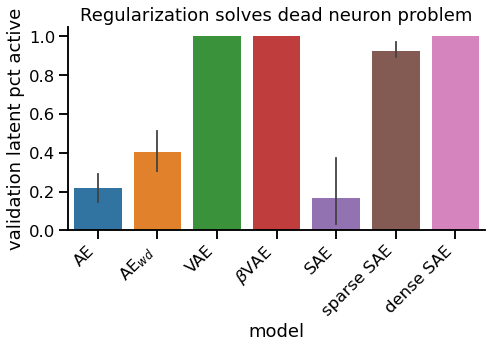

Testing for differences in validation latent pct active with alpha = 0.05
Model: AE
Mean & std. 0.22 +- 0.09
Data          [0.22006369 0.3        0.07012739 0.32012739 0.19012739]

Model: AE_wd
Mean & std. 0.41 +- 0.13
Data          [0.41191083 0.62165605 0.44025478 0.28273885 0.27025478]

Model: VAE
Mean & std. 1.00 +- 0.00
Data          [1. 1. 1. 1. 1.]

Model: VAE_beta
Mean & std. 1.00 +- 0.00
Data          [1. 1. 1. 1. 1.]

Model: SAE
Mean & std. 0.17 +- 0.20
Data          [0.54063694 0.19133758 0.04       0.02006369 0.04      ]

Model: SAE_sparse
Mean & std. 0.93 +- 0.04
Data          [0.95828025 0.88738854 0.89452229 0.99719745 0.89573248]

Model: SAE_dense
Mean & std. 1.00 +- 0.00
Data          [1. 1. 1. 1. 1.]

Kurskal Wallis:  H = 32.03, p = 1.61e-05 ****

Post hoc comparisons n = 21
alpha after Bonferroni correction = 2.38e-03

Comparing models AE & AE_wd:
Welch's t test:  t = -2.38, p = 4.81e-02 n.s.

Comparing models AE & VAE:
Welch's t test:  t = -17.49, p = 6.28e-05 **

C

(32.02894056847546, 1.6110477159357646e-05)

In [15]:
# Regularization solves dead neuron problem

title = "Regularization solves dead neuron problem"
var = "validation latent pct active"

plot_variables_in_barplot(results_default, var, all_models,
                          "model", title=title, save=f"{var}.svg")

kruskal_with_posthoc(results_default, var, all_models, epoch=10)

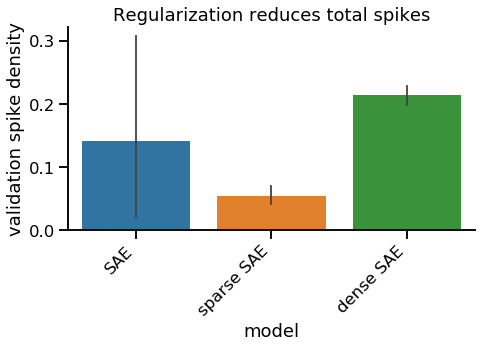

Testing for differences in validation spike density with alpha = 0.05
Model: SAE
Mean & std. 0.14 +- 0.18
Data          [0.48924222 0.14901633 0.03226201 0.01290267 0.02490072]

Model: SAE_sparse
Mean & std. 0.05 +- 0.02
Data          [0.04398258 0.03758109 0.06520838 0.08102911 0.04647714]

Model: SAE_dense
Mean & std. 0.21 +- 0.02
Data          [0.20825434 0.1839345  0.23309823 0.23449078 0.20871132]

Kurskal Wallis:  H = 6.00, p = 4.98e-02 *

Post hoc comparisons n = 3
alpha after Bonferroni correction = 1.67e-02

Comparing models SAE & SAE_sparse:
Welch's t test:  t = 0.96, p = 3.92e-01 n.s.

Comparing models SAE & SAE_dense:
Welch's t test:  t = -0.79, p = 4.71e-01 n.s.

Comparing models SAE_sparse & SAE_dense:
Welch's t test:  t = -12.91, p = 1.52e-06 ****



(6.0, 0.04978706836786395)

In [14]:
# Regularization reduces total spike density

title = "Regularization reduces total spikes"
var = "validation spike density"

plot_variables_in_barplot(results_default, var,
                          sae_models, "model", title=title, save=f"{var}.svg")

kruskal_with_posthoc(results_default, var, sae_models, epoch=10)

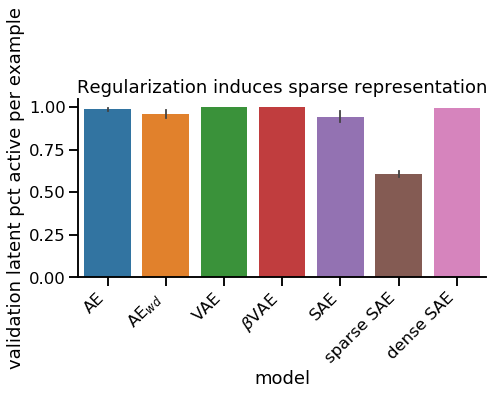

Testing for differences in validation latent pct active per example with alpha = 0.05
Model: AE
Mean & std. 0.99 +- 0.01
Data          [0.99581633 0.99416468 0.97029615 0.99693441 0.99304523]

Model: AE_wd
Mean & std. 0.96 +- 0.03
Data          [0.98292718 0.92321069 0.92366134 0.97818905 0.98761685]

Model: VAE
Mean & std. 1.00 +- 0.00
Data          [1. 1. 1. 1. 1.]

Model: VAE_beta
Mean & std. 1.00 +- 0.00
Data          [1.       0.999999 1.       1.       1.      ]

Model: SAE
Mean & std. 0.95 +- 0.04
Data          [0.98684483 0.98383365 0.95101015 0.88272956 0.92359176]

Model: SAE_sparse
Mean & std. 0.61 +- 0.02
Data          [0.62688265 0.62792542 0.62438764 0.59280447 0.58267984]

Model: SAE_dense
Mean & std. 1.00 +- 0.00
Data          [0.99572751 0.99300458 0.99460092 0.99576334 0.99761644]

Kurskal Wallis:  H = 31.30, p = 2.22e-05 ****

Post hoc comparisons n = 21
alpha after Bonferroni correction = 2.38e-03

Comparing models AE & AE_wd:
Welch's t test:  t = 2.00, p = 1.03e-01

(31.303247863247858, 2.2183637229931657e-05)

In [15]:
# Regularization induces sparsity in space

title = "Regularization induces sparse representation"
var = "validation latent pct active per example"

plot_variables_in_barplot(results_default, var, 
                          all_models, "model", title=title, save=f"{var}.svg")

kruskal_with_posthoc(results_default, var, all_models, epoch=10)

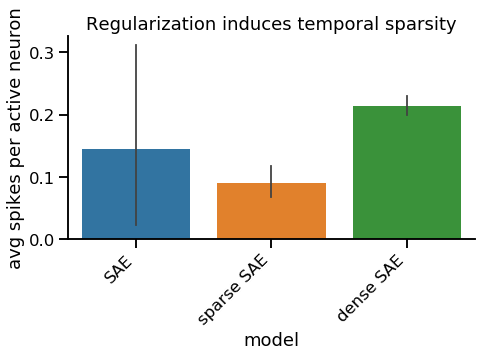

Testing for differences in avg spikes per active neuron with alpha = 0.05
Model: SAE
Mean & std. 0.14 +- 0.18
Data          [0.49576408 0.15146497 0.03392394 0.01461678 0.02696074]

Model: SAE_sparse
Mean & std. 0.09 +- 0.03
Data          [0.07016079 0.05984961 0.10443573 0.13668775 0.07976446]

Model: SAE_dense
Mean & std. 0.21 +- 0.02
Data          [0.20914792 0.18523027 0.23436358 0.23548847 0.20920998]

Kurskal Wallis:  H = 6.00, p = 4.98e-02 *

Post hoc comparisons n = 3
alpha after Bonferroni correction = 1.67e-02

Comparing models SAE & SAE_sparse:
Welch's t test:  t = 0.59, p = 5.86e-01 n.s.

Comparing models SAE & SAE_dense:
Welch's t test:  t = -0.77, p = 4.86e-01 n.s.

Comparing models SAE_sparse & SAE_dense:
Welch's t test:  t = -7.48, p = 1.36e-04 ***



(6.0, 0.04978706836786395)

In [16]:
# Regularization induces sparsity in time

results_default['avg spikes per active neuron'] = results_default["validation spike density"] / results_default["validation latent pct active per example"]

title = "Regularization induces temporal sparsity"
var = "avg spikes per active neuron"

plot_variables_in_barplot(results_default, var, 
                          sae_models, "model", title=title, save=f"{var}.svg")

kruskal_with_posthoc(results_default, var, sae_models, epoch=10)

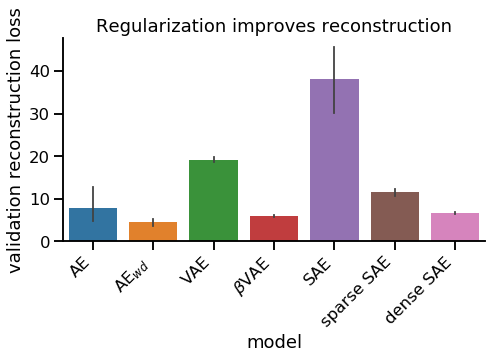

Testing for differences in validation reconstruction loss with alpha = 0.05
Model: AE
Mean & std. 7.89 +- 4.83
Data          [ 6.17141483  4.5397906  17.33337165  4.33535134  7.05613406]

Model: AE_wd
Mean & std. 4.67 +- 0.98
Data          [4.64408959 2.77988249 5.23233045 5.48080218 5.21845571]

Model: VAE
Mean & std. 19.09 +- 0.66
Data          [18.48179327 18.71085523 18.98456315 20.36288099 18.89057546]

Model: VAE_beta
Mean & std. 5.94 +- 0.21
Data          [6.04044667 5.85287638 5.90626352 6.26014604 5.62996161]

Model: SAE
Mean & std. 38.09 +- 8.98
Data          [27.4948917  27.52414623 46.08154812 48.4416068  40.89032811]

Model: SAE_sparse
Mean & std. 11.58 +- 0.89
Data          [11.6364166  12.56886288 11.66485122  9.92627544 12.1001579 ]

Model: SAE_dense
Mean & std. 6.75 +- 0.26
Data          [6.70499125 7.15719109 6.48036906 6.50091647 6.91971169]

Kurskal Wallis:  H = 29.55, p = 4.78e-05 ****

Post hoc comparisons n = 21
alpha after Bonferroni correction = 2.38e-03

Compa

(29.554285714285726, 4.77679222492495e-05)

In [25]:
# Regularization improves reconstruction loss

title = "Regularization improves reconstruction"
var = "validation reconstruction loss"

plot_variables_in_barplot(results_default, var, 
                          all_models, "model", title=title, save=f"{var}.svg")

kruskal_with_posthoc(results_default, var, all_models, epoch=10)

{'AE_wd': 'AE$_{wd}$', 'VAE_beta': '$\\beta$VAE', 'SAE_sparse': 'sparse SAE', 'SAE_dense': 'dense SAE'}


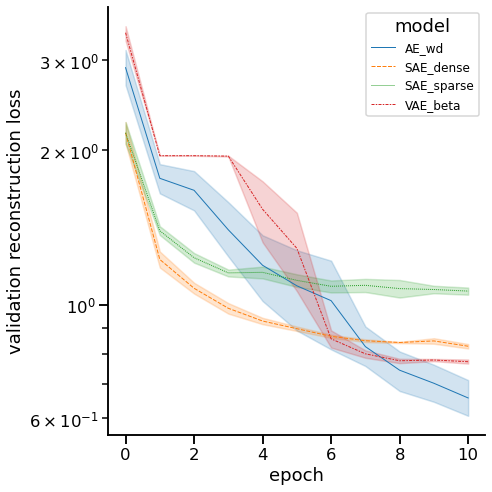

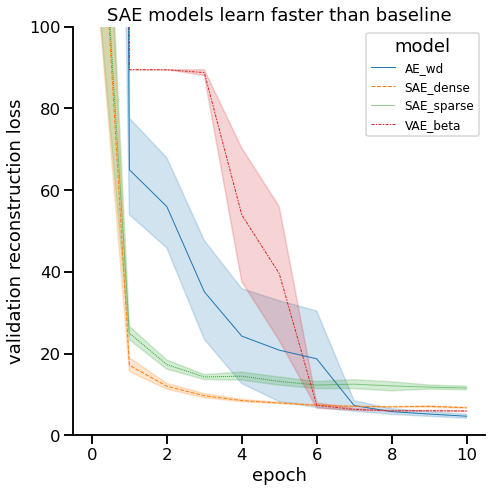

In [24]:
# Regularized spiking model learns faster compared to baseline
var = "validation reconstruction loss"
title = "SAE models learn faster than baseline"

reduced_models = {k: v for k, v in all_models.items() if k in ["AE_wd", "VAE_beta", "SAE_sparse", "SAE_dense"]}
print(reduced_models)

#plot_variables_over_time(results_default, var, all_models, hue="model", ylog=True)
#plot_variables_over_time(results_default, var, all_models, hue="model", ymax=100 ,start_epoch=0)

#plot_variables_over_time(results_default, var, sae_models, hue="model", style="model", ylog=True)
#plot_variables_over_time(results_default, var, sae_models, hue="model", style="model", ymax=100, start_epoch=0)

#plot_variables_over_time(results_default, var, non_sae_models, hue="model", style="model", ylog=True)
#plot_variables_over_time(results_default, var, non_sae_models, hue="model", style="model", ymax=100, start_epoch=0)

plot_variables_over_time(results_default, var, reduced_models, hue="model", style="model", ylog=True)
plot_variables_over_time(results_default, var, reduced_models, hue="model",
                         style="model", ymax=100, start_epoch=0, title=title, save=f"{var} time.svg")

In [23]:
for e in range(11):
    print(f"EPOCH {e}\n")
    kruskal_with_posthoc(results_default, var, reduced_models, epoch=e)

EPOCH 0

Testing for differences in validation reconstruction loss with alpha = 0.05
Model: AE_wd
Mean & std. 1596.45 +- 2009.30
Data          [1147.09238857  580.03146712 5565.03054557  531.87897137  158.22725537]

Model: VAE_beta
Mean & std. 2829.52 +- 1484.72
Data          [2617.11154739 2938.32490452 2020.00929523 5510.13392746 1062.02920979]

Model: SAE_sparse
Mean & std. 169.94 +- 96.19
Data          [ 88.36614631  94.81654445 243.31542978 323.65678124  99.55285659]

Model: SAE_dense
Mean & std. 169.94 +- 96.19
Data          [ 88.36614631  94.81654445 243.31542978 323.65678124  99.55285659]

Kurskal Wallis:  H = 12.97, p = 4.71e-03 **

Post hoc comparisons n = 6
alpha after Bonferroni correction = 8.33e-03

Comparing models AE_wd & VAE_beta:
Welch's t test:  t = -0.99, p = 3.55e-01 n.s.

Comparing models AE_wd & SAE_sparse:
Welch's t test:  t = 1.42, p = 2.29e-01 n.s.

Comparing models AE_wd & SAE_dense:
Welch's t test:  t = 1.42, p = 2.29e-01 n.s.

Comparing models VAE_beta & SA

In [ ]:
df = results_default[results_default["epoch"]==10]
df = df.sort_values(by =['model', 'seed', 'epoch'])
df = df[variables + ['model', 'seed']]


In [ ]:
sns.pairplot(df, vars = variables, hue="model")


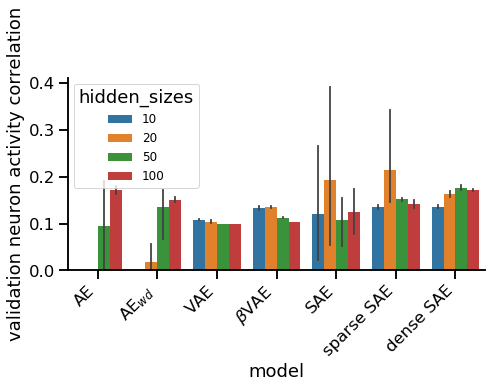

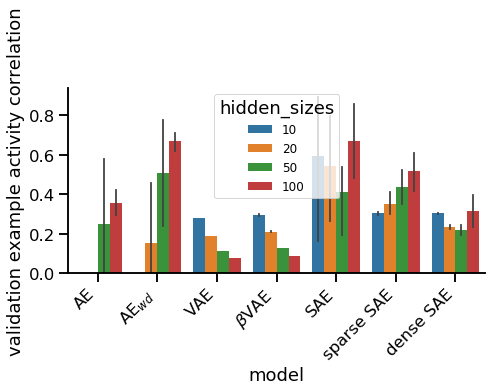

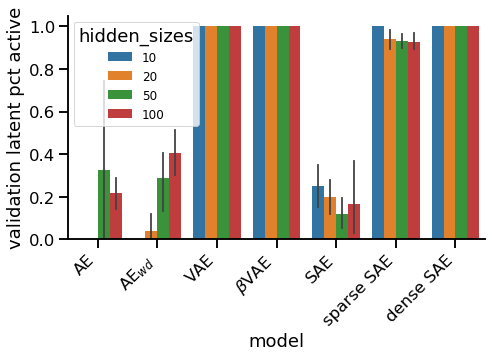

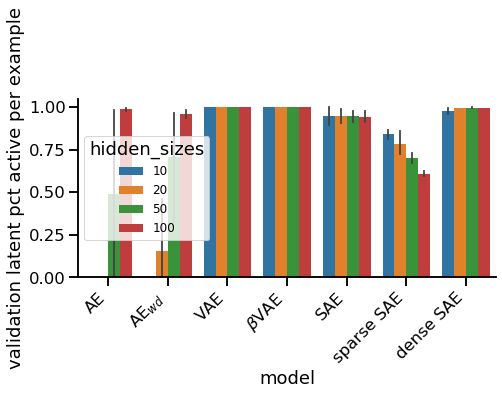

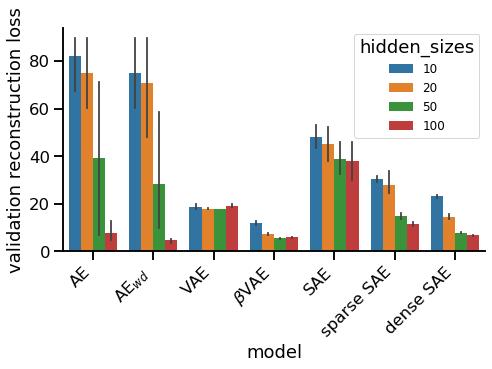

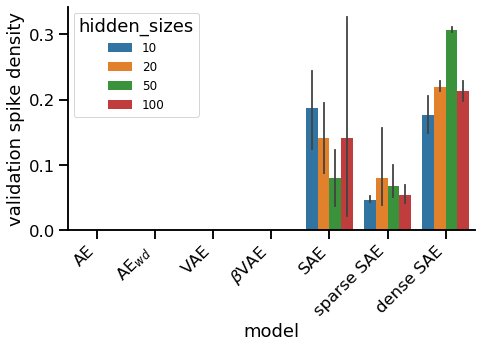

In [49]:
for var in variables:
    plot_variables_in_barplot(results_size, var, all_models, "model", hue="hidden_sizes") #, ylog=True)